# Scouting

## Radar Plot

Raw Data from Wyscout:
- Non-penalty goals
- Assists
- Key passes
- Smart passes
- Ariel duels won
- Ground attacking duels won

Calculate:
- Non penalty expected goals
- passes ending in final third
- receptions in final third

In [1]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### 1. Opening the data

In [2]:
path = os.path.join(str(pathlib.Path().resolve().parent), 'Wyscout', 'events',
                    'events_England.json')  # delete #
with open(path) as f:
    data = json.load(f)
events = pd.DataFrame(data)

### 2. Calculating xG value

In [3]:
def calulatexG(df, npxG):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.
    npxG : boolean
        True if xG should not include penalties, False elsewhere.

    Returns
    -------
    xG_sum: dataframe
        dataframe with sum of Expected Goals for players during the season.

    """
    #very basic xG model based on
    shots = df.loc[df["eventName"] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell:
                                       (100 - cell[0]['x']) * 105 / 100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68 / 100)
    shots["C"] = shots.positions.apply(
        lambda cell: abs(cell[0]['y'] - 50) * 68 / 100)
    #calculate distance and angle
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(
        np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 -
                                       (7.32 / 2)**2)) > 0,
        np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 -
                                       (7.32 / 2)**2)),
        np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 -
                                       (7.32 / 2)**2)) + np.pi)
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {
        'id': 101
    } in x else 0).astype(object)
    #headers have id = 403
    headers = shots.loc[shots.apply(lambda x: {'id': 403} in x.tags, axis=1)]
    non_headers = shots.drop(headers.index)

    headers_model = smf.glm(formula="Goal ~ Distance + Angle",
                            data=headers,
                            family=sm.families.Binomial()).fit()
    #non-headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle",
                               data=non_headers,
                               family=sm.families.Binomial()).fit()
    #assigning xG
    #headers
    b_head = headers_model.params
    xG = 1 / (1 + np.exp(b_head[0] + b_head[1] * headers['Distance'] +
                         b_head[2] * headers['Angle']))
    headers = headers.assign(xG=xG)

    #non-headers
    b_nhead = nonheaders_model.params
    xG = 1 / (1 + np.exp(b_nhead[0] + b_nhead[1] * non_headers['Distance'] +
                         b_nhead[2] * non_headers['Angle']))
    non_headers = non_headers.assign(xG=xG)

    if npxG == False:
        #find pens
        penalties = df.loc[df["subEventName"] == "Penalty"]
        #assign 0.8
        penalties = penalties.assign(xG=0.8)
        #concat, group and sum
        all_shots_xg = pd.concat([
            non_headers[["playerId", "xG"]], headers[["playerId", "xG"]],
            penalties[["playerId", "xG"]]
        ])
        xG_sum = all_shots_xg.groupby([
            "playerId"
        ])["xG"].sum().sort_values(ascending=False).reset_index()
    else:
        #concat, group and sum
        all_shots_xg = pd.concat(
            [non_headers[["playerId", "xG"]], headers[["playerId", "xG"]]])
        all_shots_xg.rename(columns={"xG": "npxG"}, inplace=True)
        xG_sum = all_shots_xg.groupby([
            "playerId"
        ])["npxG"].sum().sort_values(ascending=False).reset_index()
    #group by player and sum

    return xG_sum


#making function
npxg = calulatexG(events, npxG=True)
#investigate structure
npxg.head(3)

,playerId,npxG
0,8717,22.014180
1,120353,17.215819
2,11066,14.144484


### 3. Calculating passes ending in final third and receptions in final third

In [4]:
def FinalThird(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    final_third: dataframe
        dataframe with number of passes ending in final third and receptions in that area for a player.

    """
    df = df.copy()
    #need player who had received the ball
    df["nextPlayerId"] = df["playerId"].shift(-1)
    passes = df.loc[events["eventName"] == "Pass"].copy()
    #changing coordinates
    passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

    #get accurate passes
    accurate_passes = passes.loc[passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    #get passes into final third
    final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]

    #passes into final third by player
    ftp_player = final_third_passes.groupby(["playerId"]).end_x.count().reset_index()
    ftp_player.rename(columns = {'end_x':'final_third_passes'}, inplace=True)

    #receptions of accurate passes in the final third
    rtp_player = final_third_passes.groupby(["nextPlayerId"]).end_x.count().reset_index()
    rtp_player.rename(columns = {'end_x':'final_third_receptions', "nextPlayerId": "playerId"}, inplace=True)

    #outer join not to lose values
    final_third = ftp_player.merge(rtp_player, how = "outer", on = ["playerId"])
    return final_third

final_third = FinalThird(events)
#investigate structure
final_third.head(3)

,playerId,final_third_passes,final_third_receptions
0,36.0,186.0,83.0
1,38.0,62.0,66.0
2,48.0,392.0,188.0


### 4. Calculating air and ground duels won

In [5]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player

    """
    #find air duels
    air_duels = df.loc[df["subEventName"] == "Air duel"]
    #703 is the id of a won duel
    won_air_duels = air_duels.loc[air_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]

    #group and sum air duels
    wad_player =  won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)

    #find ground duels won
    ground_duels = df.loc[df["subEventName"].isin(["Ground attacking duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]

    wgd_player =  won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'ground_duels_won'}, inplace=True)

    #outer join
    duels_won = wgd_player.merge(wad_player, how = "outer", on = ["playerId"])
    return duels_won

duels = wonDuels(events)
#investigate structure
duels.head(3)

,playerId,ground_duels_won,air_duels_won
0,0,2244.0,1061.0
1,36,13.0,23.0
2,38,7.0,11.0


### 5. Calculating smart passes

In [6]:
def smartPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    sp_player: dataframe
        dataframe with number of smart passes.

    """
    #get smart passes
    smart_passes = df.loc[df["subEventName"] == "Smart pass"]
    #find accurate
    smart_passes_made = smart_passes.loc[smart_passes.apply(
        lambda x: {'id': 1801} in x.tags, axis=1)]

    #sum by player
    sp_player = smart_passes_made.groupby(["playerId"
                                           ]).eventId.count().reset_index()
    sp_player.rename(columns={'eventId': 'smart_passes'}, inplace=True)

    return sp_player


smart_passes = smartPasses(events)
#investigate structure
smart_passes.head(3)

,playerId,smart_passes
0,36,1
1,38,1
2,48,3


### 6. Goals, Assists, Key Passes

In [7]:
def GoalsAssistsKeyPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    data: dataframe
        dataframe with number of (non-penalty) goals, assists and key passes.

    """
    #get goals
    shots = df.loc[df["subEventName"] == "Shot"]
    goals = shots.loc[shots.apply(lambda x: {'id': 101} in x.tags, axis=1)]
    #get assists
    passes = df.loc[df["eventName"] == "Pass"]
    assists = passes.loc[passes.apply(lambda x: {'id': 301} in x.tags, axis=1)]
    #get key passes
    key_passes = passes.loc[passes.apply(lambda x: {'id': 302} in x.tags,
                                         axis=1)]

    #goals by player
    g_player = goals.groupby(["playerId"]).eventId.count().reset_index()
    g_player.rename(columns={'eventId': 'goals'}, inplace=True)

    #assists by player
    a_player = assists.groupby(["playerId"]).eventId.count().reset_index()
    a_player.rename(columns={'eventId': 'assists'}, inplace=True)

    #key passes by player
    kp_player = key_passes.groupby(["playerId"]).eventId.count().reset_index()
    kp_player.rename(columns={'eventId': 'key_passes'}, inplace=True)

    data = g_player.merge(a_player, how="outer",
                          on=["playerId"]).merge(kp_player,
                                                 how="outer",
                                                 on=["playerId"])
    return data


gakp = GoalsAssistsKeyPasses(events)
#investigate structure
gakp.head(3)

,playerId,goals,assists,key_passes
0,54,10.0,5.0,25.0
1,74,1.0,NaN,1.0
2,93,2.0,5.0,14.0


### 7. Minutes played

In [8]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]),'Wyscout', 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

### 8. Summary Table

In [9]:
players = events["playerId"].unique()
summary = pd.DataFrame(players, columns=["playerId"])
summary = summary.merge(npxg, how="left", on=["playerId"]).merge(
    final_third, how="left",
    on=["playerId"]).merge(duels, how="left",
                           on=["playerId"]).merge(smart_passes,
                                                  how="left",
                                                  on=["playerId"
                                                      ]).merge(gakp,
                                                               how="left",
                                                               on=["playerId"])

summary = minutes.merge(summary, how="left", on=["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

In [10]:
summary.head()

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes
0,36,1238,0.604683,186.0,83.0,13.0,23.0,1.0,0.0,0.0,2.0
2,48,3343,1.236777,392.0,188.0,50.0,137.0,3.0,0.0,0.0,3.0
3,54,3348,6.350951,818.0,800.0,102.0,15.0,42.0,10.0,5.0,25.0
5,74,1514,0.472400,115.0,41.0,14.0,48.0,4.0,1.0,0.0,1.0
6,93,2942,3.449038,265.0,365.0,141.0,42.0,7.0,2.0,5.0,14.0


### 9. Filtering positions

In [11]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]),
                    'Wyscout', 'players.json')
with open(path) as f:
    players = json.load(f)
player_df = pd.DataFrame(players)
forwards = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Forward",
                                         axis=1)]
forwards.rename(columns={'wyId': 'playerId'}, inplace=True)
to_merge = forwards[['playerId', 'shortName']]
summary = summary.merge(to_merge, how="inner", on=["playerId"])

In [13]:
summary.sample(5)

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes,shortName
70,286831,647,3.491209,78.0,122.0,31.0,22.0,4.0,1.0,2.0,4.0,D. Solanke
24,8747,1666,4.079526,98.0,183.0,26.0,248.0,1.0,5.0,2.0,3.0,P. Crouch
30,9206,1673,6.925811,113.0,196.0,42.0,82.0,1.0,10.0,1.0,4.0,C. Wood
66,230883,2598,7.288210,222.0,310.0,149.0,45.0,12.0,8.0,4.0,11.0,Ayoze P\u00e9rez
43,15808,2852,7.799890,436.0,531.0,152.0,49.0,32.0,14.0,4.0,13.0,Roberto Firmino


### 10. Calculating statistics per 90

In [14]:
summary_per_90 = pd.DataFrame()
summary_per_90["shortName"] = summary["shortName"]
for column in summary.columns[2:-1]:
    summary_per_90[column + "_per90"] = summary.apply(
        lambda x: x[column] * 90 / x["minutesPlayed"], axis=1)

### 11. Finding values for player

In [17]:
#player to investigate - Mohammed Salah
#only his statistics
salah = summary_per_90.loc[summary_per_90["shortName"] == "Mohamed Salah"]
#columns similar together
salah = salah[[
    'npxG_per90', "goals_per90", "assists_per90", "key_passes_per90",
    "smart_passes_per90", "final_third_passes_per90",
    "final_third_receptions_per90", "ground_duels_won_per90",
    "air_duels_won_per90"
]]
#take only necessary columns - exclude playerId
per_90_columns = salah.columns[:]
#values to mark on the plot
values = [round(salah[column].iloc[0], 2) for column in per_90_columns]
#percentiles
percentiles = [
    int(stats.percentileofscore(summary_per_90[column], salah[column].iloc[0]))
    for column in per_90_columns
]

In [25]:
salah

,npxG_per90,goals_per90,assists_per90,key_passes_per90,smart_passes_per90,final_third_passes_per90,final_third_receptions_per90,ground_duels_won_per90,air_duels_won_per90
61,0.517337,0.931553,0.210351,0.330551,0.751252,12.681135,18.631052,5.979967,0.300501


### 12. Plot

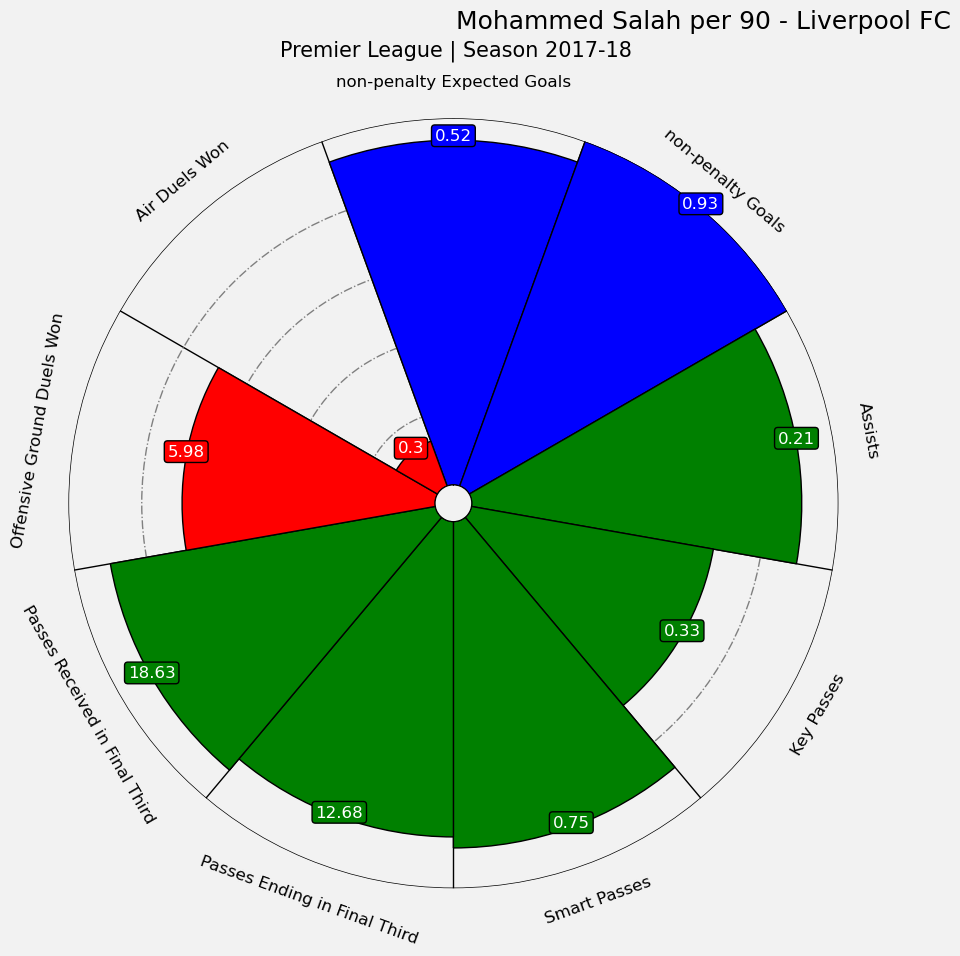

In [35]:
#list of names on plots
names = [
    "non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes",
    "Smart Passes", "Passes Ending in Final Third",
    "Passes Received in Final Third", "Offensive Ground Duels Won",
    "Air Duels Won"
]
slice_colors = ["blue"] * 2 + ["green"] * 5 + ["red"] * 2
text_colors = ["white"] * 9

#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range=None,
    max_range=None,  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,  # linewidth for straight lines
    last_circle_lw=1,  # linewidth of last circle
    other_circle_lw=1,  # linewidth for other circles
    other_circle_ls="-."  # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,  # list of values
    figsize=(10, 10),  # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors=text_colors,
    value_bck_colors=slice_colors,  # where the parameters will be added
    kwargs_slices=dict(facecolor="cornflowerblue",
                       edgecolor="#000000",
                       zorder=2,
                       linewidth=1),  # values to be used when plotting slices
    kwargs_params=dict(color="#000000", fontsize=12,
                       va="center"),  # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000",
        fontsize=12,
        bbox=dict(edgecolor="#000000",
                  facecolor="cornflowerblue",
                  boxstyle="round,pad=0.2",
                  lw=1))  # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(0.515, 0.97, "Mohammed Salah per 90 - Liverpool FC", size=18)

# add subtitle
fig.text(0.515,
         0.942,
         "Premier League | Season 2017-18",
         size=15,
         ha="center",
         color="#000000")
plt.show()


## Adjusting Possessions

In [36]:
minutes_per_game

,playerId,shortName,matchId,teamId,teamName,player_in_min,player_out_min,minutesPlayed,red_card
0,9206,C. Wood,2500089,1646,Burnley FC,0,61,61,0
1,9127,S. Vokes,2500089,1646,Burnley FC,61,95,34,0
2,93,J. Gu\u00f0munds\u00adson,2500089,1646,Burnley FC,0,80,80,0
3,9179,N. Wells,2500089,1646,Burnley FC,80,95,15,0
4,10108,K. Long,2500089,1646,Burnley FC,0,95,95,0
...,...,...,...,...,...,...,...,...,...
10438,8488,W. Morgan,2499719,1631,Leicester City FC,0,95,95,0
10439,14853,C. Fuchs,2499719,1631,Leicester City FC,0,95,95,0
10440,265366,W. Ndidi,2499719,1631,Leicester City FC,0,95,95,0
10441,12829,J. Vardy,2499719,1631,Leicester City FC,0,95,95,0


In [37]:
possesion_dict = {}
#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row[
        "matchId"]
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possesion_dict.keys():
        possesion_dict[str(player_id)] = {'team_passes': 0, 'all_passes': 0}
    min_in = row["player_in_min"] * 60
    min_out = row["player_out_min"] * 60

    #get the dataframe of events from the game
    match_df = events.loc[events["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] = match_df.loc[
        match_df["matchPeriod"] == "2H", 'eventSec'] + match_df.loc[
            match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1]
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[
        match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(
        ["Pass", "Duel"])]
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"].isin([
            "Air duel", "Ground defending duel", "Ground loose ball duel"
        ])].loc[all_passes.apply(lambda x: {'id': 701} in x.tags, axis=1)]
        all_passes = all_passes.drop(no_contact.index)
    #take team passes
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
    possesion_dict[str(player_id)]["all_passes"] += len(all_passes)

#calculate possesion for each player
percentage_dict = {
    key:
    value["team_passes"] /
    value["all_passes"] if value["all_passes"] > 0 else 0
    for key, value in possesion_dict.items()
}
#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(),
                             columns=["playerId", "possesion"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)
#merge it
summary = summary.merge(percentage_df, how="left", on=["playerId"])

In [ ]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]
#calculate value adjusted
for column in summary.columns[2:11]:
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(
        lambda x: (x[column] / x["possesion"]) * 90 / x["minutesPlayed"],
        axis=1)